In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 25.7 MB/s 
     |████████████████████████████████| 6.6 MB 47.1 MB/s 
     |████████████████████████████████| 120 kB 74.2 MB/s 


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel

import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split


In [3]:
os.environ["WANDB_API_KEY"] = "0" ## to silence warning

In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [5]:
# hyperparameters
max_length = 140
batch_size = 32
dev_size = 0.2

In [6]:
# Bert Tokenizer
model_name = "bert-base-multilingual-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

In [7]:
train_df = pd.read_csv('/content/drive/MyDrive/paper_5/Experiment with Hnglish Dataset/cm_hinglish_f.csv')

In [8]:
!pip install pyspellchecker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 15.2 MB/s 


In [9]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
#text = "speling correctin"
#correct_spellings(text)
correct_spellings(train_df.to_string())

TypeError: ignored

In [10]:
train_df.head()

,Unnamed: 0,text,label
0,0,Triple Talaq par Burbak Kuchh nahi bolega,0
1,1,Batao ye uss site pr se akki sir ke verdict ni...,1
2,2,Hindu baheno par julam bardas nahi hoga @Tripl...,0
3,3,Naa bhai.. aisa nhi hai.. mere handle karne se...,0
4,4,#RememberingRajiv aaj agar musalman auraten tr...,0


In [11]:
train_df.rename(columns = {'Unnamed: 0':'id'}, inplace = True)
train_df.head()

,id,text,label
0,0,Triple Talaq par Burbak Kuchh nahi bolega,0
1,1,Batao ye uss site pr se akki sir ke verdict ni...,1
2,2,Hindu baheno par julam bardas nahi hoga @Tripl...,0
3,3,Naa bhai.. aisa nhi hai.. mere handle karne se...,0
4,4,#RememberingRajiv aaj agar musalman auraten tr...,0


In [12]:
train, dev = train_test_split(train_df, test_size=dev_size, random_state=42)

In [13]:
def bert_encode(data):
    tokens = tokenizer.batch_encode_plus(data, max_length=max_length, padding='max_length', truncation=True)
    
    return tf.constant(tokens['input_ids'])

In [14]:
train

,id,text,label
378,378,#TripleTalaq khatam ho gaya aur #RamRahimSingh...,0
4789,4789,Pakistan se jis din se hara hai Cricket dekhn...,0
3469,3469,Me yahi chahta ho insafi b Roo or patwari b sa...,0
2503,2503,Aur hame us ladki se jise cricket se pyaar hai...,0
1580,1580,Ab hamare desh ki muslim shadi shuda mahilao p...,0
...,...,...,...
3092,3092,Darbhanga ke mp ek true sportsman hai jo har p...,0
3772,3772,Publicity stunt...Hindu dharm ko bachane ke li...,0
5191,5191,@PvTanna naam liya aur shaitan ka phone aaya W...,0
5226,5226,"@mehv_ Acha hua aapne #sarcasm likh diya, aapi ;)",0


In [15]:
train_encoded = bert_encode(train.text)
dev_encoded = bert_encode(dev.text)


train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_encoded, train.label))
    .shuffle(100)
    .batch(batch_size)
)

dev_dataset = (
    tf.data.Dataset
    .from_tensor_slices((dev_encoded, dev.label))
    .shuffle(100)
    .batch(batch_size)
)

In [16]:
def bert_tweets_model():
    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
    last_hidden_states = bert_encoder(input_word_ids)[0]    
    x = tf.keras.layers.LSTM(100, dropout=0.3, recurrent_dropout=0.3)(last_hidden_states)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=input_word_ids, outputs=output)
    
    return model

In [17]:
with strategy.scope():
    model = bert_tweets_model()
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(loss='binary_crossentropy',optimizer=adam_optimizer,metrics=['accuracy'])

    model.summary()

Some layers from the model checkpoint at bert-base-multilingual-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 140)]             0         
                                                                 
 tf_bert_model (TFBertModel)  TFBaseModelOutputWithPoo  167356416
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             140, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

In [18]:
history = model.fit(
    train_dataset,
    batch_size=batch_size,
    epochs=2,
    validation_data=dev_dataset,
    verbose=2)
    #callbacks=[tf.keras.callbacks.EarlyStopping(
    #            patience=6,
    #            min_delta=0.05,
    #            baseline=0.7,
    #            mode='min',
    #            monitor='val_accuracy',
    #            restore_best_weights=True,
    #            verbose=1)
    #          ])

Epoch 1/2


132/132 - 233s - loss: 0.2258 - accuracy: 0.9107 - val_loss: 0.1263 - val_accuracy: 0.9495 - 233s/epoch - 2s/step
Epoch 2/2
132/132 - 221s - loss: 0.1075 - accuracy: 0.9500 - val_loss: 0.1170 - val_accuracy: 0.9514 - 221s/epoch - 2s/step


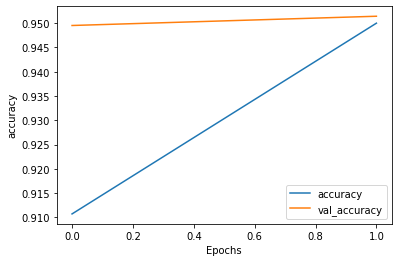

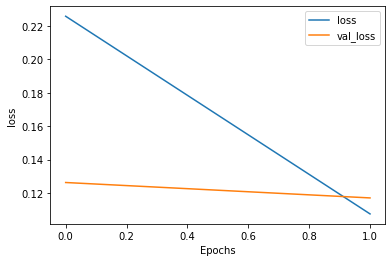

In [19]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [20]:
test, val = train_test_split(dev, test_size=dev_size, random_state=42)

In [21]:
dev.shape

(1050, 3)

In [22]:
test.head()

,id,text,label
4441,4441,Mery Bhai wo 8 saal phly ki baat hai agar ab c...,0
602,602,Aap Muslim Khatoon Se Guzarish Hai Ki Aag Aaye...,0
3184,3184,Nasaf Mudat Puri Honey K Dawran Sharjeel Ka Ra...,0
4463,4463,Pakistan wale barma k liye kuch karo ya bas cr...,0
3679,3679,Kehne ke liye toh 1000 followers hai par baat...,1


In [23]:
test_encoded = bert_encode(dev.text)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_encoded)
    .batch(batch_size)
)

predicted_tweets = model.predict(test_dataset, batch_size=batch_size)
predicted_tweets_binary = tf.cast(tf.round(predicted_tweets), tf.int32).numpy().flatten()
print(predicted_tweets_binary)
my_submission = pd.DataFrame({'id': dev.id, 'label': predicted_tweets_binary})
my_submission.to_csv('/content/drive/MyDrive/paper_5/Experiment with Hnglish Dataset/my_submission.csv', index=False)

[0 0 0 ... 0 0 1]


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn import metrics

In [ ]:
print("Bert+LSTM")
print("Accuracy score =", accuracy_score(dev['label'], predicted_tweets_binary))
print(metrics.classification_report(dev['label'], predicted_tweets_binary))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j],fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

def plot_AUC_ROC(y_true, y_pred):
    n_classes = 2

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(label_test.ravel(), predictions_test1.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
############################################################################################
    lw = 2
    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    #plt.show()

    # Plot of a ROC curve for a specific class
    '''
    plt.figure()
    lw = 2
    plt.plot(fpr[0], tpr[0], color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    '''

In [ ]:
predictions_test = model.predict(dev['label'])
predictions_test1 = np.zeros_like(predictions_test)
predictions_test1[np.arange(len(predictions_test)), predictions_test.argmax(1)] = 1

In [ ]:
dev1 = np.zeros_like(dev['label'])
#dev1[np.arange(len(dev1)), dev1.argmax(1)] = 1
print(dev1,dev['label'])

In [ ]:
#classification report for test sample
classes_list = ['Not-sarcasm', 'sarcasm']
Class_report_result= []
accuracy_score_result =[]
ROC_AUC_score_result = []
predictions_test = predicted_tweets
predictions_test1 = np.zeros_like(predictions_test)
predictions_test1[np.arange(len(predictions_test)), predictions_test.argmax(1)] = 1
Class_report = metrics.classification_report(dev['label'],predictions_test1)
    
print(metrics.classification_report(dev1,predictions_test1, target_names = classes_list ))
Class_report_result.append(Class_report)

from sklearn.metrics import accuracy_score
print("Accuracy score =", accuracy_score(dev1,predictions_test1))
accuracy_score_result.append(accuracy_score(dev1,predictions_test1))

from sklearn.metrics import roc_auc_score
print("ROC_AUC score =", roc_auc_score(dev1,predictions_test))
ROC_AUC_score_result.append(roc_auc_score(dev1,predictions_test))
    
plt.clf()
cnf_matrix = metrics.confusion_matrix(dev1.argmax(axis =1),predictions_test1.argmax(axis = 1))
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix, classes = classes_list, normalize = True)
   #plt.show()
plt.savefig("bert-lstm_"+ str(i) +"Confusion.pdf", format = 'pdf', dpi =1000)
plt.clf()
plot_AUC_ROC(dev['label'], predictions_test)
plt.savefig("bert-lstm"+ str(i) +"ROC.pdf", format = 'pdf', dpi =1000)
i=i+1

# the function 'report_average' is used to do the average of all the classification report coming from K-fold
report_ave = report_average(Class_report_result[0],Class_report_result[1], Class_report_result[2], Class_report_result[3], Class_report_result[4])
print (Class_report_result[0])
print (Class_report_result[1])
print (Class_report_result[2])
print (Class_report_result[3])
print (Class_report_result[4])
print (report_ave)

print("Average accuracy score = ", np.mean(accuracy_score_result))

print("Average ROC AUC score = ", np.mean(ROC_AUC_score_result))
